# Import Libraries

In [1]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Models

In [2]:
core = ov.Core()

# face model
model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name="CPU")

input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

print(f"Input shape: {input_layer_face.shape}")
print(f"Output shape: {output_layer_face.shape}")

# emotion model
model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name="CPU")

input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

print(f"Input shape: {input_layer_emo.shape}")
print(f"Output shape: {output_layer_emo.shape}")

# age, gender model
model_ag = core.read_model(model='models/age-gender-recognition-retail-0013.xml')
compiled_model_ag = core.compile_model(model = model_emo, device_name="CPU")

input_layer_ag = compiled_model_ag.input(0)
output_layer_ag = compiled_model_ag.output(0)

print(f"Input shape: {input_layer_ag.shape}")
print(f"Output shape: {output_layer_ag.shape}")

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]
Input shape: [1,3,64,64]
Output shape: [1,5,1,1]


RuntimeError: Exception from src\inference\src\cpp\core.cpp:92:
Exception from src\inference\src\model_reader.cpp:160:
Unable to read the model: models/age-gender-recognition-retail-0013.xml Please check that model format: xml is supported and the model is correct. Available frontends: ir onnx paddle pytorch tf tflite 



# Functions

In [8]:
import numpy as np

def preprocess(image, input_layer_face):
    N, input_channels, input_height, input_width = input_layer_face.shape

    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)

    return input_image

In [9]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:, 2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes * np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores


In [10]:
def draw_faceboxes(image, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)

    return show_image


In [11]:
def draw_emotions(face_boxes, image, show_image):
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin:ymax, xmin:xmax]
        
        input_image = preprocess(image, input_layer_emo)
        results_emo = compiled_model_emo([input_image])[output_layer_emo]
    
        results_emo = results_emo.squeeze()
        index = np.argmax(results_emo)
    
        text = EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 20)

In [21]:
def draw_age_gender(face_boxes, image, show_image):
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin:ymax, xmin:xmax]
        
        input_image_ag = preprocess(image, input_layer_ag)
        results_ag = compiled_model_ag([input_image_ag])
        age, gender = results_ag[1], results_ag[0]
        age = np.squeeze(age)
        
        print(f"Age: {age}")
        print(f"Gender: {gender}")
        
        # text = EMOTION_NAMES[index]
        # cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 20)

# Do Inference

In [20]:
image = cv2.imread("data/person.jpg")

input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]

confidence_threshold = .95

face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_faceboxes(image, face_boxes, scores)
draw_emotions(face_boxes, image, show_image)
draw_age_gender(face_boxes, image, show_image)

# plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

KeyError: 1

[0.32 0.1  0.34 0.15 0.09] 2 sad


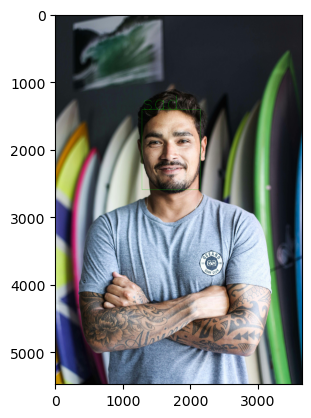

In [26]:
EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surprise', 'anger']
for i in range(len(face_boxes)):
    xmin, ymin, xmax, ymax = face_boxes[i]
    face = image[ymin:ymax, xmin:xmax]
    
    input_image = preprocess(image, input_layer_emo)
    results_emo = compiled_model_emo([input_image])[output_layer_emo]

    results_emo = results_emo.squeeze()
    index = np.argmax(results_emo)

    text = EMOTION_NAMES[index]
    cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 2)

    print(np.round(results_emo, 2), index, text)
    plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))